In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Input, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from gensim.models import Word2Vec, FastText
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer

In [2]:
# --- Load dataset function ---
def load_data(folder_path):
    data = []
    labels = []
    for label in ['pos', 'neg']:
        path = os.path.join(folder_path, label)
        for file_name in os.listdir(path):
            file_path = os.path.join(path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
                data.append(text)
                labels.append(label)
    return pd.DataFrame({'text': data, 'label': labels})

# Load the data
train_data = load_data(r'D:\MCA - 2024\DEEP LEARNING\sentiment_analysis\train')
test_data = load_data(r'D:\MCA - 2024\DEEP LEARNING\sentiment_analysis\test')

In [3]:
# --- Preprocess text data ---
def preprocess_text(train_texts, test_texts, max_num_words=10000, max_sequence_length=200):
    tokenizer = Tokenizer(num_words=max_num_words)
    tokenizer.fit_on_texts(train_texts)
    X_train = tokenizer.texts_to_sequences(train_texts)
    X_test = tokenizer.texts_to_sequences(test_texts)
    X_train = pad_sequences(X_train, maxlen=max_sequence_length)
    X_test = pad_sequences(X_test, maxlen=max_sequence_length)
    return X_train, X_test, tokenizer

X_train, X_test, tokenizer = preprocess_text(train_data['text'], test_data['text'])

In [4]:
# Label encoding
train_data['label'] = train_data['label'].map({'pos': 1, 'neg': 0})
test_data['label'] = test_data['label'].map({'pos': 1, 'neg': 0})
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [5]:
# --- GloVe ---
def load_glove_embeddings(glove_file, tokenizer, embedding_dim=100):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    word_index = tokenizer.word_index
    num_words = min(len(word_index) + 1, tokenizer.num_words)
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_index.items():
        if i >= tokenizer.num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

glove_file = r"D:\MCA - 2024\DEEP LEARNING\glove.6B.100d.txt"
embedding_dim = 100
glove_embedding_matrix = load_glove_embeddings(glove_file, tokenizer, embedding_dim)

In [6]:
# --- Word2Vec ---
def train_word2vec(sentences, embedding_dim=100):
    w2v_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)
    w2v_model.train(sentences, total_examples=len(sentences), epochs=5)
    return w2v_model

def create_embedding_matrix(word2vec_model, tokenizer, embedding_dim=100):
    word_index = tokenizer.word_index
    num_words = min(len(word_index) + 1, tokenizer.num_words)
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_index.items():
        if i >= tokenizer.num_words:
            continue
        if word in word2vec_model.wv.key_to_index:
            embedding_matrix[i] = word2vec_model.wv[word]
    return embedding_matrix

train_sentences = [text.split() for text in train_data['text']]
w2v_model = train_word2vec(train_sentences, embedding_dim=embedding_dim)
word2vec_embedding_matrix = create_embedding_matrix(w2v_model, tokenizer, embedding_dim)

In [7]:
# --- FastText ---
def train_fasttext_model(train_texts, vector_size=100):
    sentences = [text.split() for text in train_texts]
    fasttext_model = FastText(sentences, vector_size=vector_size, window=5, min_count=1, sg=1)
    fasttext_model.train(sentences, total_examples=len(sentences), epochs=5)
    return fasttext_model

fasttext_model = train_fasttext_model(train_data['text'])

def text_to_fasttext_embedding(fasttext_model, texts, max_sequence_length=200):
    embedding_matrix = []
    for text in texts:
        words = text.split()
        sentence_embedding = []
        for word in words:
            if word in fasttext_model.wv:
                sentence_embedding.append(fasttext_model.wv[word])
            else:
                sentence_embedding.append(np.zeros(fasttext_model.vector_size))
        if len(sentence_embedding) > max_sequence_length:
            sentence_embedding = sentence_embedding[:max_sequence_length]
        else:
            sentence_embedding += [np.zeros(fasttext_model.vector_size)] * (max_sequence_length - len(sentence_embedding))
        embedding_matrix.append(sentence_embedding)
    return np.array(embedding_matrix)

X_train_fasttext = text_to_fasttext_embedding(fasttext_model, train_data['text'])
X_test_fasttext = text_to_fasttext_embedding(fasttext_model, test_data['text'])


In [8]:

# --- Attention Layer ---
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

In [9]:
# --- Build RNN Model ---
def build_rnn_model(max_sequence_length, embedding_matrix, embedding_dim, rnn_type='LSTM'):
    input_layer = Input(shape=(max_sequence_length,))
    embedding_layer = Embedding(embedding_matrix.shape[0],
                                embedding_dim,
                                weights=[embedding_matrix],
                                trainable=False)(input_layer)
    dropout_layer = SpatialDropout1D(0.2)(embedding_layer)

    if rnn_type == 'LSTM':
        rnn_layer = Bidirectional(LSTM(128, return_sequences=True))(dropout_layer)
    elif rnn_type == 'GRU':
        rnn_layer = Bidirectional(GRU(128, return_sequences=True))(dropout_layer)

    attention_layer = AttentionLayer()(rnn_layer)
    output_layer = Dense(1, activation='sigmoid')(attention_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=0.001), 
                  metrics=['accuracy'])
    return model

In [17]:
def train_and_evaluate(embedding_matrix, rnn_type, title, is_fasttext=False):
    if is_fasttext:
        input_layer = Input(shape=(X_train_fasttext.shape[1], X_train_fasttext.shape[2]))
    else:
        input_layer = Input(shape=(X_train.shape[1],))

    # For GloVe and Word2Vec embeddings (use Embedding layer)
    if not is_fasttext:  
        embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_dim,
                                    weights=[embedding_matrix],
                                    trainable=False)(input_layer)
        dropout_layer = SpatialDropout1D(0.2)(embedding_layer)
    else:
        # For FastText embeddings, we don't need the Embedding layer
        dropout_layer = SpatialDropout1D(0.2)(input_layer)

    # Apply RNN layers (LSTM or GRU)
    if rnn_type == 'LSTM':
        rnn_layer = Bidirectional(LSTM(128, return_sequences=True))(dropout_layer)
    elif rnn_type == 'GRU':
        rnn_layer = Bidirectional(GRU(128, return_sequences=True))(dropout_layer)

    # Attention layer
    attention_layer = AttentionLayer()(rnn_layer)

    # Output layer
    output_layer = Dense(1, activation='sigmoid')(attention_layer)

    # Compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=0.001), 
                  metrics=['accuracy'])

    # Early stopping and model training
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train if not is_fasttext else X_train_fasttext, 
                        y_train, 
                        validation_data=(X_test if not is_fasttext else X_test_fasttext, y_test), 
                        epochs=5, batch_size=32, callbacks=[early_stopping])

    # Save the model
    model.save(f"{title}.h5")
    print(f"Model saved as {title}.h5")

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test if not is_fasttext else X_test_fasttext, y_test)
    print(f"\n{title} - Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    # Confusion Matrix
    predictions = (model.predict(X_test if not is_fasttext else X_test_fasttext) > 0.5).astype(int)
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'{title} - Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Error Rate
    error_rate = 1 - test_accuracy
    print(f"{title} - Error Rate: {error_rate}")

    # Plot history: Accuracy & Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    return test_accuracy, error_rate, cm


Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 66s 137ms/step - accuracy: 0.6422 - loss: 0.6209 - val_accuracy: 0.7800 - val_loss: 0.4848
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 59s 134ms/step - accuracy: 0.7872 - loss: 0.4606 - val_accuracy: 0.8398 - val_loss: 0.3649
Epoch 3/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 59s 134ms/step - accuracy: 0.8145 - loss: 0.4057 - val_accuracy: 0.8498 - val_loss: 0.3386
Epoch 4/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 59s 135ms/step - accuracy: 0.8387 - loss: 0.3686 - val_accuracy: 0.8507 - val_loss: 0.3316
Epoch 5/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 63s 144ms/step - accuracy: 0.8500 - loss: 0.3405 - val_accuracy: 0.8662 - val_loss: 0.3185


Model saved as LSTM with GloVe.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.8592 - loss: 0.3433

LSTM with GloVe - Test Loss: 0.318503201007843, Test Accuracy: 0.8661666512489319
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step


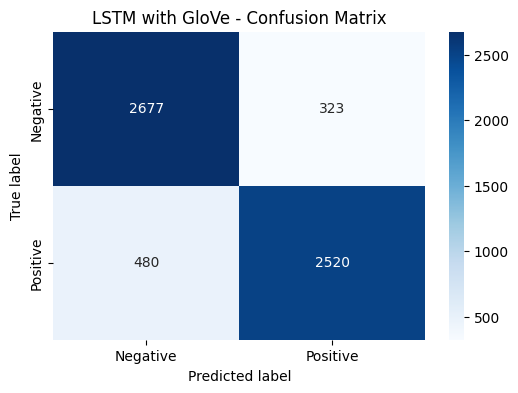

LSTM with GloVe - Error Rate: 0.13383334875106812


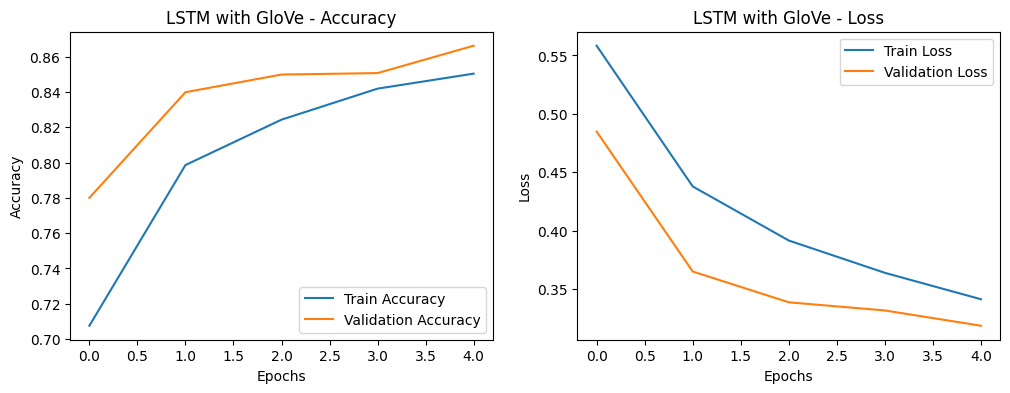

Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 68s 148ms/step - accuracy: 0.6878 - loss: 0.5863 - val_accuracy: 0.8357 - val_loss: 0.3725
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 63s 143ms/step - accuracy: 0.8292 - loss: 0.3854 - val_accuracy: 0.8633 - val_loss: 0.3139
Epoch 3/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 62s 142ms/step - accuracy: 0.8609 - loss: 0.3230 - val_accuracy: 0.8795 - val_loss: 0.2871
Epoch 4/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 61s 140ms/step - accuracy: 0.8850 - loss: 0.2870 - val_accuracy: 0.8720 - val_loss: 0.2900
Epoch 5/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 59s 135ms/step - accuracy: 0.8887 - loss: 0.2658 - val_accuracy: 0.8895 - val_loss: 0.2703


Model saved as LSTM with Word2Vec.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9021 - loss: 0.2409

LSTM with Word2Vec - Test Loss: 0.2703181207180023, Test Accuracy: 0.8895000219345093
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step


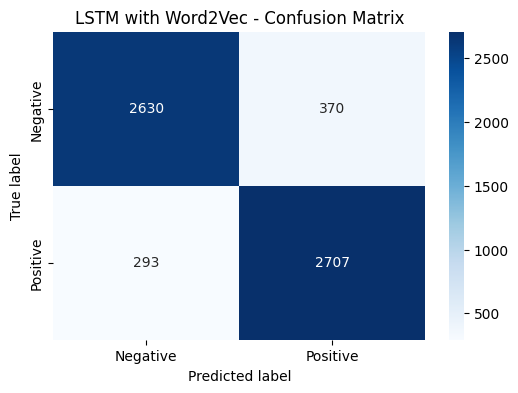

LSTM with Word2Vec - Error Rate: 0.11049997806549072


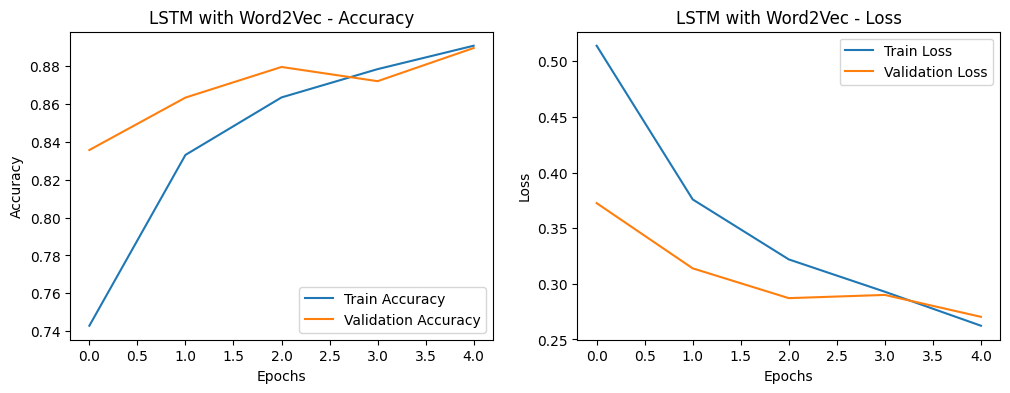

Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 66s 142ms/step - accuracy: 0.6461 - loss: 0.6079 - val_accuracy: 0.8285 - val_loss: 0.3831
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 60s 136ms/step - accuracy: 0.8130 - loss: 0.4091 - val_accuracy: 0.8488 - val_loss: 0.3457
Epoch 3/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 60s 136ms/step - accuracy: 0.8408 - loss: 0.3568 - val_accuracy: 0.8565 - val_loss: 0.3256
Epoch 4/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 60s 138ms/step - accuracy: 0.8505 - loss: 0.3443 - val_accuracy: 0.8658 - val_loss: 0.3115
Epoch 5/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 66s 152ms/step - accuracy: 0.8611 - loss: 0.3214 - val_accuracy: 0.8680 - val_loss: 0.3025


Model saved as GRU with GloVe.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.8773 - loss: 0.2966

GRU with GloVe - Test Loss: 0.3024708330631256, Test Accuracy: 0.8679999709129333
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step


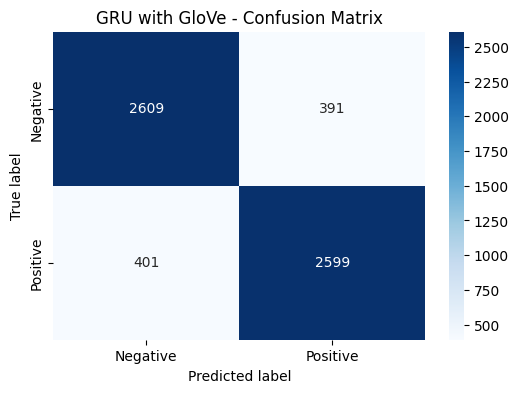

GRU with GloVe - Error Rate: 0.13200002908706665


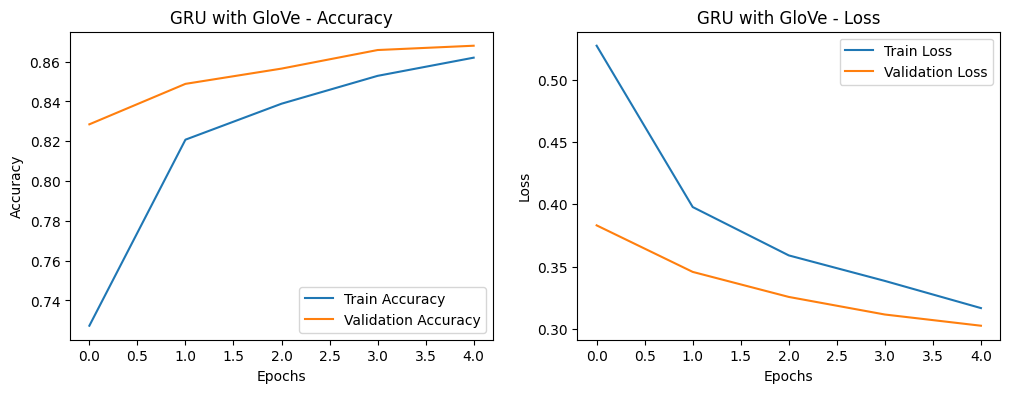

Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 66s 142ms/step - accuracy: 0.6642 - loss: 0.5886 - val_accuracy: 0.8347 - val_loss: 0.3730
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 61s 140ms/step - accuracy: 0.8288 - loss: 0.3842 - val_accuracy: 0.8685 - val_loss: 0.3053
Epoch 3/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 61s 140ms/step - accuracy: 0.8668 - loss: 0.3186 - val_accuracy: 0.8700 - val_loss: 0.3013
Epoch 4/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 61s 140ms/step - accuracy: 0.8749 - loss: 0.2925 - val_accuracy: 0.8777 - val_loss: 0.2944
Epoch 5/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 69s 157ms/step - accuracy: 0.8942 - loss: 0.2536 - val_accuracy: 0.8815 - val_loss: 0.2889


Model saved as GRU with Word2Vec.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9098 - loss: 0.2301

GRU with Word2Vec - Test Loss: 0.28886133432388306, Test Accuracy: 0.8815000057220459
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step


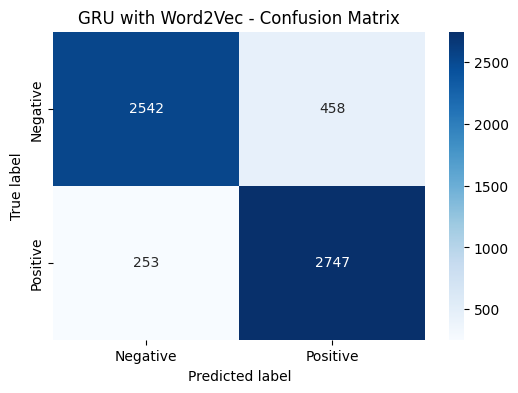

GRU with Word2Vec - Error Rate: 0.1184999942779541


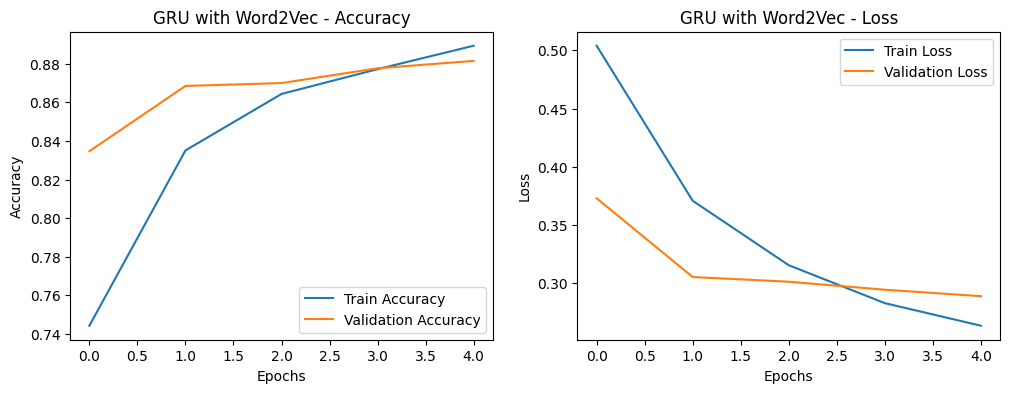

Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 71s 154ms/step - accuracy: 0.6468 - loss: 0.6272 - val_accuracy: 0.7893 - val_loss: 0.4572
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 63s 144ms/step - accuracy: 0.7671 - loss: 0.4796 - val_accuracy: 0.7863 - val_loss: 0.4509
Epoch 3/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 60s 136ms/step - accuracy: 0.8155 - loss: 0.4099 - val_accuracy: 0.8390 - val_loss: 0.3526
Epoch 4/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 60s 137ms/step - accuracy: 0.8350 - loss: 0.3755 - val_accuracy: 0.8532 - val_loss: 0.3335
Epoch 5/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 60s 137ms/step - accuracy: 0.8351 - loss: 0.3605 - val_accuracy: 0.8603 - val_loss: 0.3225


Model saved as LSTM with FastText.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8646 - loss: 0.3224

LSTM with FastText - Test Loss: 0.32248741388320923, Test Accuracy: 0.8603333234786987
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step


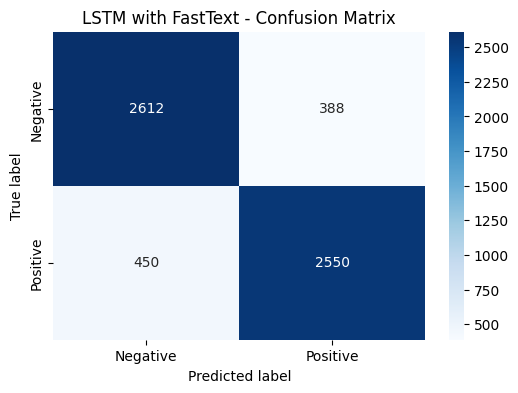

LSTM with FastText - Error Rate: 0.13966667652130127


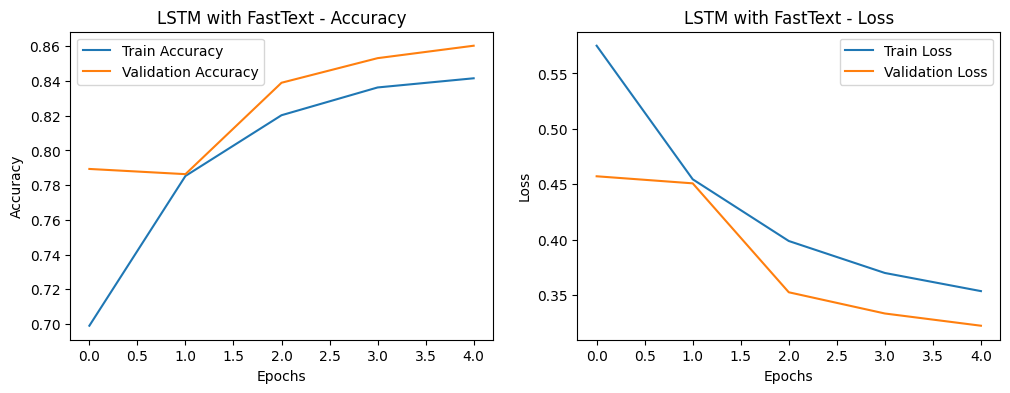

Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 69s 148ms/step - accuracy: 0.6623 - loss: 0.6022 - val_accuracy: 0.8308 - val_loss: 0.3802
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 59s 136ms/step - accuracy: 0.8159 - loss: 0.4052 - val_accuracy: 0.8418 - val_loss: 0.3612
Epoch 3/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 60s 137ms/step - accuracy: 0.8306 - loss: 0.3789 - val_accuracy: 0.8472 - val_loss: 0.3343
Epoch 4/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 60s 137ms/step - accuracy: 0.8432 - loss: 0.3512 - val_accuracy: 0.8510 - val_loss: 0.3371
Epoch 5/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 60s 138ms/step - accuracy: 0.8579 - loss: 0.3259 - val_accuracy: 0.8582 - val_loss: 0.3276


Model saved as GRU with FastText.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9149 - loss: 0.2234

GRU with FastText - Test Loss: 0.32759544253349304, Test Accuracy: 0.8581666946411133
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step


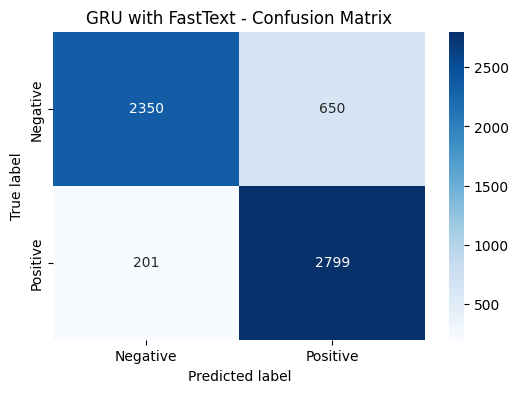

GRU with FastText - Error Rate: 0.14183330535888672


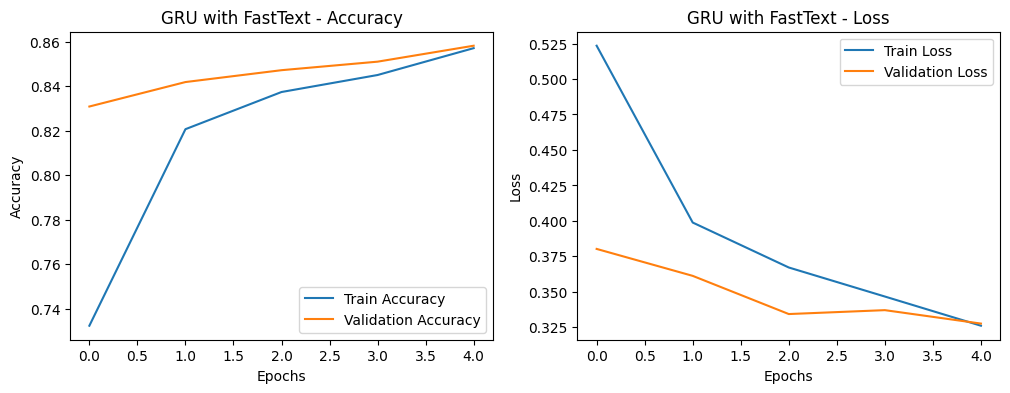

Best Model: LSTM with Word2Vec with Accuracy: 0.8895000219345093


In [18]:
# --- Evaluate models with different embeddings and RNN types ---
results = []

# GloVe and Word2Vec embeddings (use the embedding layer)
for rnn in ['LSTM', 'GRU']:
    acc, err, cm = train_and_evaluate(glove_embedding_matrix, rnn, f'{rnn} with GloVe')
    results.append((f'{rnn} with GloVe', acc, err))
    acc, err, cm = train_and_evaluate(word2vec_embedding_matrix, rnn, f'{rnn} with Word2Vec')
    results.append((f'{rnn} with Word2Vec', acc, err))

# FastText embeddings (skip embedding layer, use is_fasttext=True)
for rnn in ['LSTM', 'GRU']:
    acc, err, cm = train_and_evaluate(X_train_fasttext, rnn, f'{rnn} with FastText', is_fasttext=True)
    results.append((f'{rnn} with FastText', acc, err))

# Conclusion: Find best model
best_model = sorted(results, key=lambda x: x[1], reverse=True)[0]
print(f"Best Model: {best_model[0]} with Accuracy: {best_model[1]}")


In [19]:
# --- Conclusion ---
best_model = sorted(results, key=lambda x: x[1], reverse=True)[0]
print(f"Best Model: {best_model[0]} with Accuracy: {best_model[1]}")


Best Model: LSTM with Word2Vec with Accuracy: 0.8895000219345093
